# Lab 4 – Generative Models with PyTorch

In this lab, we explore different generative models using PyTorch.  
The objective is to understand how neural networks can learn data distributions and generate new samples.

The lab is divided into two main parts:
- Autoencoders and Variational Autoencoders
- Generative Adversarial Networks


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="/kaggle/working",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="/kaggle/working",
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Train:", len(train_dataset), "Test:", len(test_dataset))


100%|██████████| 9.91M/9.91M [00:00<00:00, 29.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.98MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.76MB/s]

Train: 60000 Test: 10000


### Autoencoder Architecture

An Autoencoder is composed of two main parts:
- Encoder: compresses the input into a low-dimensional latent representation.
- Decoder: reconstructs the original input from the latent space.

The model is trained by minimizing the reconstruction error between the input image and the reconstructed image.


In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


In [5]:
latent_dim = 32
ae = AutoEncoder(latent_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

epochs = 20
ae_losses = []


In [6]:
for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(x.size(0), -1).to(device)
        
        x_hat, _ = ae(x)
        loss = criterion(x_hat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    ae_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.0402
Epoch [2/20], Loss: 0.0151
Epoch [3/20], Loss: 0.0113
Epoch [4/20], Loss: 0.0096
Epoch [5/20], Loss: 0.0086
Epoch [6/20], Loss: 0.0079
Epoch [7/20], Loss: 0.0074
Epoch [8/20], Loss: 0.0070
Epoch [9/20], Loss: 0.0067
Epoch [10/20], Loss: 0.0065
Epoch [11/20], Loss: 0.0063
Epoch [12/20], Loss: 0.0061
Epoch [13/20], Loss: 0.0060
Epoch [14/20], Loss: 0.0058
Epoch [15/20], Loss: 0.0057
Epoch [16/20], Loss: 0.0056
Epoch [17/20], Loss: 0.0055
Epoch [18/20], Loss: 0.0054
Epoch [19/20], Loss: 0.0054
Epoch [20/20], Loss: 0.0053


### Autoencoder Results

The training loss decreases steadily, indicating that the model successfully learns to reconstruct the input images.

The reconstructed images are visually close to the original MNIST digits, showing that the latent representation captures essential features.

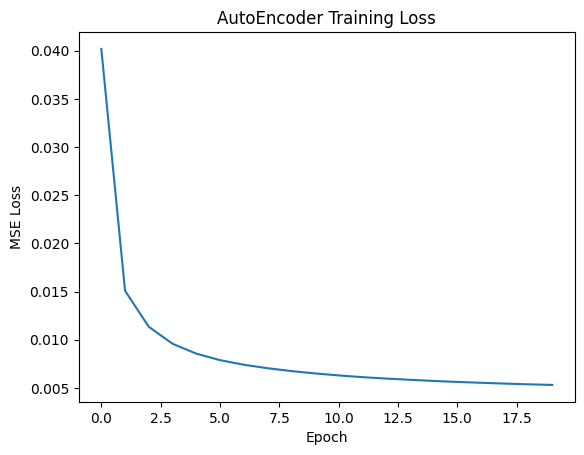

In [25]:
plt.plot(ae_losses)
plt.title("AutoEncoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.savefig("results/MSE_Losses.png")
plt.show()


In [26]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256, 28*28)
        
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [27]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl, recon_loss, kl


In [28]:
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

vae_losses, kl_losses = [], []

for epoch in range(epochs):
    total_loss, total_kl = 0, 0
    for x, _ in train_loader:
        x = x.view(x.size(0), -1).to(device)
        
        recon, mu, logvar = vae(x)
        loss, _, kl = vae_loss(recon, x, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_kl += kl.item()
        
    vae_losses.append(total_loss / len(train_loader))
    kl_losses.append(total_kl / len(train_loader))
    
    print(f"Epoch {epoch+1}, Loss: {vae_losses[-1]:.2f}, KL: {kl_losses[-1]:.2f}")


Epoch 1, Loss: 23143.21, KL: 1897.37
Epoch 2, Loss: 17480.20, KL: 2772.38
Epoch 3, Loss: 15936.28, KL: 2990.74
Epoch 4, Loss: 15029.35, KL: 3081.22
Epoch 5, Loss: 14538.36, KL: 3142.51
Epoch 6, Loss: 14281.46, KL: 3193.63
Epoch 7, Loss: 14100.97, KL: 3216.42
Epoch 8, Loss: 13975.40, KL: 3242.79
Epoch 9, Loss: 13877.57, KL: 3262.95
Epoch 10, Loss: 13812.59, KL: 3278.26
Epoch 11, Loss: 13756.81, KL: 3290.51
Epoch 12, Loss: 13704.94, KL: 3295.31
Epoch 13, Loss: 13671.76, KL: 3300.66
Epoch 14, Loss: 13629.11, KL: 3305.97
Epoch 15, Loss: 13601.04, KL: 3309.93
Epoch 16, Loss: 13569.18, KL: 3309.03
Epoch 17, Loss: 13546.79, KL: 3309.06
Epoch 18, Loss: 13521.89, KL: 3310.90
Epoch 19, Loss: 13511.51, KL: 3317.15
Epoch 20, Loss: 13486.20, KL: 3314.65
Epoch 21, Loss: 13471.72, KL: 3318.77
Epoch 22, Loss: 13448.16, KL: 3316.17
Epoch 23, Loss: 13441.64, KL: 3321.13
Epoch 24, Loss: 13423.39, KL: 3320.17
Epoch 25, Loss: 13410.06, KL: 3318.51
Epoch 26, Loss: 13400.39, KL: 3318.95
Epoch 27, Loss: 13386

### VAE Results and Analysis

Compared to the Autoencoder, the VAE produces smoother reconstructions.

The KL divergence enforces a structured latent space, which allows interpolation and sampling of new data points.

This regularization comes at the cost of slightly blurrier reconstructions.

In [29]:
RESULTS_DIR = "/kaggle/working/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

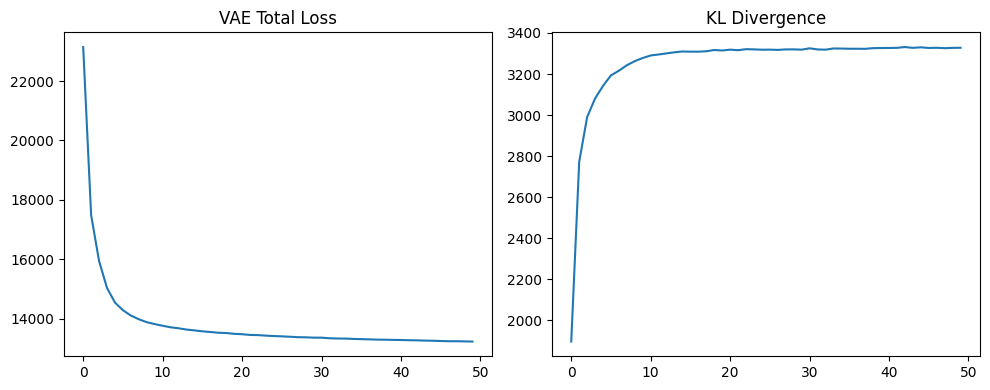

In [30]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(vae_losses)
plt.title("VAE Total Loss")

plt.subplot(1,2,2)
plt.plot(kl_losses)
plt.title("KL Divergence")

plt.tight_layout()
plt.savefig("results/VAE_Losses.png")
plt.show()

In [45]:
def plot_latent(model, loader, title, filename):
    model.eval()
    zs = []
    labels = []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.view(x.size(0), -1).to(device)
            
            if isinstance(model, AutoEncoder):
                _, z = model(x)
            else:  # VAE
                _, mu, _ = model(x)
                z = mu
            
            zs.append(z.cpu())
            labels.append(y)
    
    z = torch.cat(zs).numpy()
    labels = torch.cat(labels).numpy()
    
    plt.figure(figsize=(6,4))
    plt.scatter(z[:,0], z[:,1], c=labels, cmap="tab10", s=2)
    plt.colorbar()
    plt.title(title)
    
    plt.savefig(f"{RESULTS_DIR}/{filename}", dpi=300)
    plt.show()

### Comparison Between AE and VAE

- Autoencoder: better reconstruction quality.
- Variational Autoencoder: better latent space organization and generative capability.

The VAE is more suitable for data generation, while the Autoencoder focuses on reconstruction accuracy.

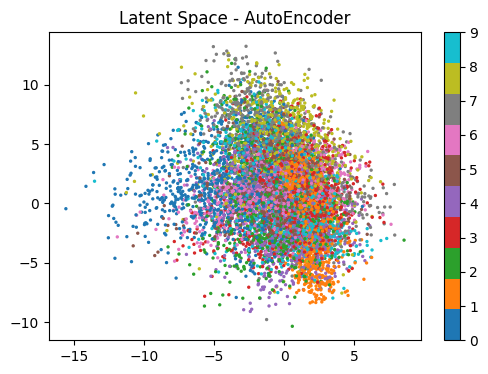

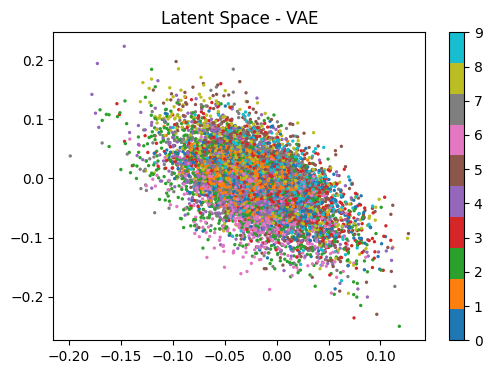

In [46]:
plot_latent(ae, test_loader,"Latent Space - AutoEncoder","latent_ae.png")

plot_latent(vae, test_loader,"Latent Space - VAE","latent_vae.png")

### Dataset: Abstract Art Gallery

This dataset contains abstract artwork images without labels.

GANs are well-suited for this task since they do not require annotated data and can learn directly from image distributions.


In [33]:
import os
import shutil

src = "/kaggle/input/atelier4-2/Abstract_gallery/Abstract_gallery"
dst = "/kaggle/working/abstract_data/art"

os.makedirs(dst, exist_ok=True)

for img in os.listdir(src):
    shutil.copy(os.path.join(src, img), dst)


In [34]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageFolder(
    root="/kaggle/working/abstract_data",
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print("Images :", len(dataset))
print("Classes :", dataset.classes)


Images : 2782
Classes : ['art']


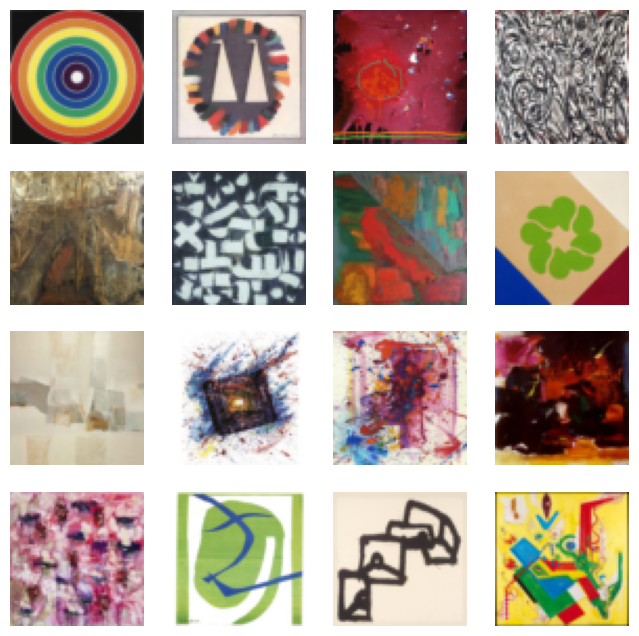

In [35]:
import matplotlib.pyplot as plt

images, _ = next(iter(dataloader))

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].permute(1,2,0) * 0.5 + 0.5)
    plt.axis("off")
plt.show()


In [36]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

latent_dim = 100      # taille du bruit
img_channels = 3
img_size = 64
batch_size = 64
epochs = 50
lr = 0.0002


Device: cuda


In [37]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, img_size * img_size * img_channels),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), img_channels, img_size, img_size)
        return img


In [38]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(img_size * img_size * img_channels, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


In [39]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


In [40]:
criterion = nn.BCELoss()

In [41]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


### GAN Training

During training:
- The Discriminator learns to distinguish real images from generated ones.
- The Generator learns to fool the Discriminator.

This adversarial process results in oscillating losses, which is a normal behavior in GAN training.

In [42]:
G_losses = []
D_losses = []

for epoch in range(epochs):
    for real_imgs, _ in dataloader:

        real_imgs = real_imgs.to(device)
        batch = real_imgs.size(0)

        real_labels = torch.ones(batch, 1).to(device)
        fake_labels = torch.zeros(batch, 1).to(device)

        # Train Discriminator
        z = torch.randn(batch, latent_dim).to(device)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")


Epoch [1/50]  D_loss: 0.5160  G_loss: 3.2009
Epoch [2/50]  D_loss: 0.3240  G_loss: 3.8598
Epoch [3/50]  D_loss: 0.3958  G_loss: 5.2940
Epoch [4/50]  D_loss: 0.4666  G_loss: 3.2000
Epoch [5/50]  D_loss: 0.2758  G_loss: 3.4992
Epoch [6/50]  D_loss: 0.9186  G_loss: 2.6673
Epoch [7/50]  D_loss: 0.7162  G_loss: 0.8741
Epoch [8/50]  D_loss: 0.5580  G_loss: 1.1792
Epoch [9/50]  D_loss: 0.6314  G_loss: 2.8997
Epoch [10/50]  D_loss: 0.5801  G_loss: 2.2890
Epoch [11/50]  D_loss: 0.3859  G_loss: 5.3401
Epoch [12/50]  D_loss: 0.6056  G_loss: 1.2936
Epoch [13/50]  D_loss: 0.6702  G_loss: 3.1068
Epoch [14/50]  D_loss: 0.3260  G_loss: 2.6898
Epoch [15/50]  D_loss: 0.5116  G_loss: 0.8063
Epoch [16/50]  D_loss: 0.6372  G_loss: 2.6368
Epoch [17/50]  D_loss: 0.6129  G_loss: 1.1718
Epoch [18/50]  D_loss: 0.3364  G_loss: 2.3283
Epoch [19/50]  D_loss: 0.4493  G_loss: 5.0567
Epoch [20/50]  D_loss: 0.2089  G_loss: 3.1503
Epoch [21/50]  D_loss: 0.4814  G_loss: 2.7217
Epoch [22/50]  D_loss: 0.7293  G_loss: 1.41

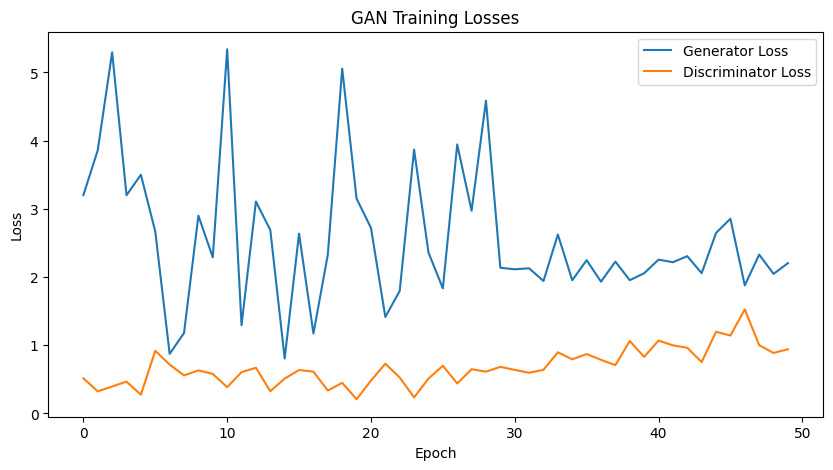

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.legend()
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig(f"{RESULTS_DIR}/gan_losses.png", dpi=300)
plt.show()

### GAN Results

The generated images show coherent textures and color distributions similar to the original abstract artworks.

Although fine details are limited, the model successfully captures the global characteristics of the dataset.

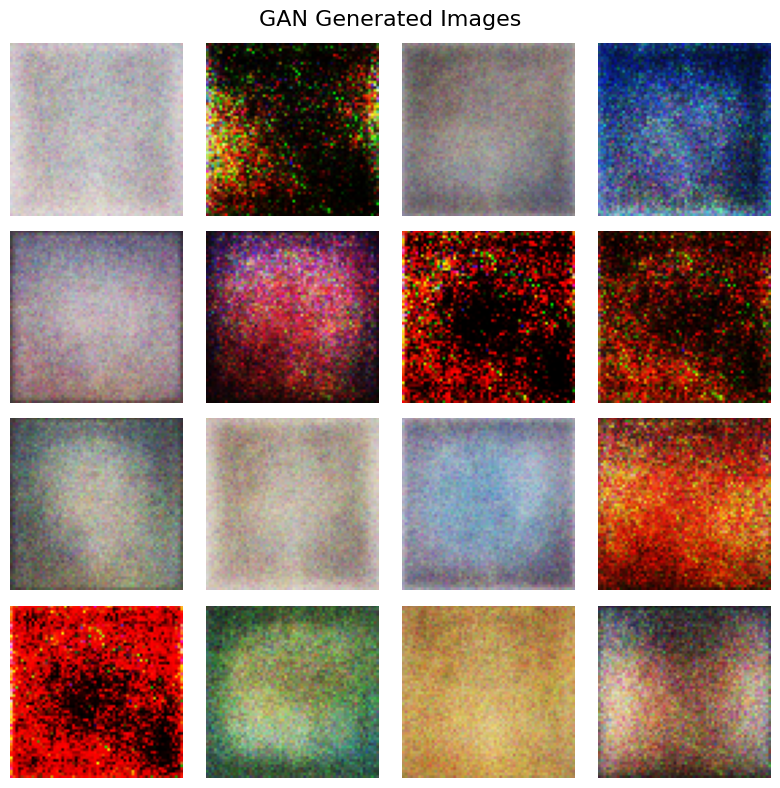

In [44]:
generator.eval()

z = torch.randn(16, latent_dim).to(device)
fake_imgs = generator(z).cpu().detach()

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fake_imgs[i].permute(1,2,0) * 0.5 + 0.5)
    plt.axis("off")

plt.suptitle("GAN Generated Images", fontsize=16)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/gan_generated_images.png", dpi=300)
plt.show()


### GAN Conclusion

GANs are powerful generative models capable of producing realistic data samples.

However, training stability and image quality depend heavily on architecture design, dataset size, and hyperparameter selection.
